In [1]:
import os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from wandb.keras import WandbMetricsLogger
import resnets as rn

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Set hyperparameters

Hyperparameters are inspired by *Deep Residual Learning for Image Recognition* by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun (2015).

In [3]:
train_path = "facial-affect-dataset-relabeled-unbalanced/train"
test_path = "facial-affect-dataset-relabeled-unbalanced/test"

image_size = 96
channels = 3
color_mode = "rgb"
validation_split = 0.2
seed = 27

config = {
    "batch_size": 32,
    "epochs": 100,
    "learning_rate": 0.1,
    "momentum": 0.9,
    "l2": 0.0001,
    "early_stop_patience": 10,
    "lr_reduce_patience": 5
}

## Run the following block on Kaggle only!

In [4]:
train_path = "/kaggle/input/" + train_path
test_path = "/kaggle/input/" + test_path

## Get class names

In [5]:
classes = next(os.walk(train_path))[1]
print(classes)

['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']


## Create training, validation and test datasets

In [6]:
train, validation = image_dataset_from_directory(
    directory=train_path,
    validation_split=validation_split,
    subset="both",
    labels="inferred",
    class_names=classes,
    label_mode="int",
    color_mode=color_mode,
    batch_size=config["batch_size"],
    image_size=(image_size, image_size),
    seed=seed,
    shuffle=True
)

test = image_dataset_from_directory(
    directory=test_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    color_mode=color_mode,
    batch_size=config["batch_size"],
    image_size=(image_size, image_size),
    shuffle=False
)

Found 22930 files belonging to 8 classes.
Using 18344 files for training.
Using 4586 files for validation.
Found 5734 files belonging to 8 classes.


## Training on different models with SOTA hyperparameters

### ResNet-18 - training and evaluation

In [7]:
wandb.init(config=config, project='resnet-improved-labels', name='resnet18')

regularizer = L2(l2=config["l2"])
optimizer = SGD(learning_rate=config["learning_rate"], momentum=config["momentum"])
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = rn.ResNet18(
    len(classes),
    (image_size, image_size, channels),
    normalize=True,
    kernel_regularizer=regularizer
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

lr_schedule_sota = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=config["lr_reduce_patience"],
    verbose=1,
    mode="min"
)

callbacks = [
    early_stopping,
    lr_schedule_sota,
    WandbMetricsLogger()
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)
wandb.finish()

wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


Epoch 1/100
574/574 [==============================] - 46s 63ms/step - loss: 3.6383 - sparse_categorical_accuracy: 0.1521 - val_loss: 3.0496 - val_sparse_categorical_accuracy: 0.1546 - lr: 0.1000
Epoch 2/100
574/574 [==============================] - 19s 32ms/step - loss: 2.9447 - sparse_categorical_accuracy: 0.1545 - val_loss: 2.8469 - val_sparse_categorical_accuracy: 0.1524 - lr: 0.1000
Epoch 3/100
574/574 [==============================] - 18s 31ms/step - loss: 2.7666 - sparse_categorical_accuracy: 0.1564 - val_loss: 2.6864 - val_sparse_categorical_accuracy: 0.1531 - lr: 0.1000
Epoch 4/100
574/574 [==============================] - 19s 32ms/step - loss: 2.6237 - sparse_categorical_accuracy: 0.1565 - val_loss: 2.5580 - val_sparse_categorical_accuracy: 0.1535 - lr: 0.1000
Epoch 5/100
574/574 [==============================] - 21s 36ms/step - loss: 2.5095 - sparse_categorical_accuracy: 0.1563 - val_loss: 2.4566 - val_sparse_categorical_accuracy: 0.1520 - lr: 0.1000
Epoch 6/100
574/574 

epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,████████████████▂▂▂▂▂▁
epoch/loss,█▆▆▆▆▅▅▅▄▄▃▃▃▃▃▃▃▂▂▁▁▁
epoch/lr,█████████████████▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▁▁▁▂▂▃▃▄▄▅▅▅▅▆▇▇███
epoch/val_loss,█▇▆▆▅▅▄▃▂▁▃▁▄▂▃▃▃▁▂▃▄▅
epoch/val_sparse_categorical_accuracy,▁▁▁▁▁▁▃▄▄▅▄▆▄▅▆▅▆█████
epoch/epoch,21
epoch/learning_rate,0.001
epoch/loss,0.4323
epoch/lr,0.01


180/180 [==============================] - 8s 47ms/step - loss: 1.6199 - sparse_categorical_accuracy: 0.4637


[1.6198748350143433, 0.46372514963150024]

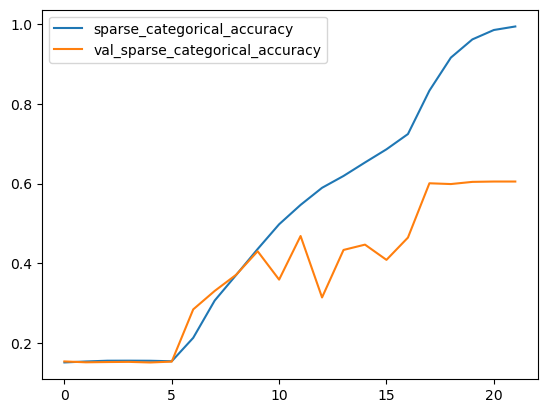

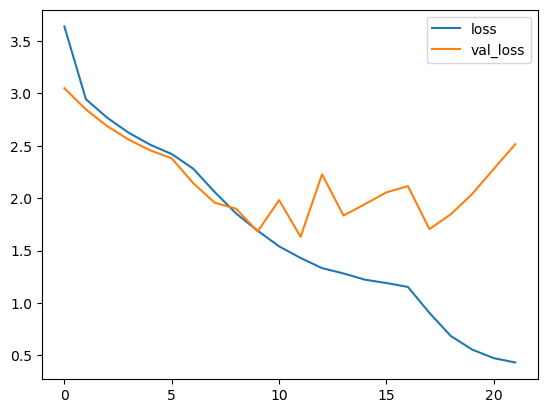

In [8]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

model.evaluate(test)

### ResNet-34 - training and evaluation

In [9]:
wandb.init(config=config, project='resnet-improved-labels', name='resnet34')

regularizer = L2(l2=config["l2"])
optimizer = SGD(learning_rate=config["learning_rate"], momentum=config["momentum"])
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = rn.ResNet34(
    len(classes),
    (image_size, image_size, channels),
    normalize=True,
    kernel_regularizer=regularizer
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

lr_schedule_sota = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=config["lr_reduce_patience"],
    verbose=1,
    mode="min"
)

callbacks = [
    early_stopping,
    lr_schedule_sota,
    WandbMetricsLogger()
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)
wandb.finish()

Epoch 1/100
574/574 [==============================] - 33s 49ms/step - loss: 5.8578 - sparse_categorical_accuracy: 0.1549 - val_loss: 4.6942 - val_sparse_categorical_accuracy: 0.1563 - lr: 0.1000
Epoch 2/100
574/574 [==============================] - 28s 48ms/step - loss: 4.4186 - sparse_categorical_accuracy: 0.1650 - val_loss: 4.1755 - val_sparse_categorical_accuracy: 0.1651 - lr: 0.1000
Epoch 3/100
574/574 [==============================] - 27s 48ms/step - loss: 3.9026 - sparse_categorical_accuracy: 0.1931 - val_loss: 3.6875 - val_sparse_categorical_accuracy: 0.2178 - lr: 0.1000
Epoch 4/100
574/574 [==============================] - 28s 48ms/step - loss: 3.4110 - sparse_categorical_accuracy: 0.2562 - val_loss: 3.2200 - val_sparse_categorical_accuracy: 0.2924 - lr: 0.1000
Epoch 5/100
574/574 [==============================] - 27s 48ms/step - loss: 2.9296 - sparse_categorical_accuracy: 0.3426 - val_loss: 2.7405 - val_sparse_categorical_accuracy: 0.3705 - lr: 0.1000
Epoch 6/100
574/574 

epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,█████████████████▂▂▂▂▂▁
epoch/loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
epoch/lr,██████████████████▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇████
epoch/val_loss,█▇▅▄▃▃▂▂▂▂▂▂▁▂▂▃▃▃▂▂▃▄▄
epoch/val_sparse_categorical_accuracy,▁▁▂▃▄▃▅▅▅▅▅▅▆▆▆▅▆▆█████
epoch/epoch,22
epoch/learning_rate,0.001
epoch/loss,0.68427
epoch/lr,0.01


180/180 [==============================] - 4s 21ms/step - loss: 1.9055 - sparse_categorical_accuracy: 0.4636


[1.9055142402648926, 0.46355074644088745]

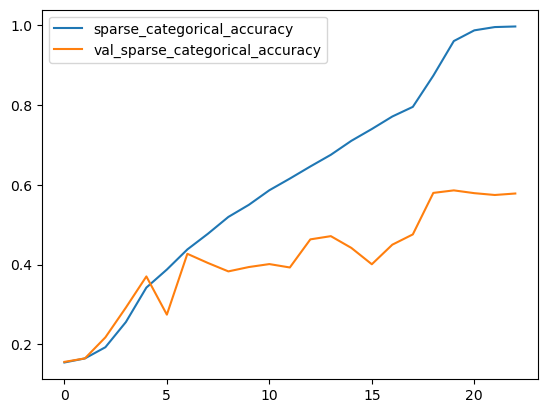

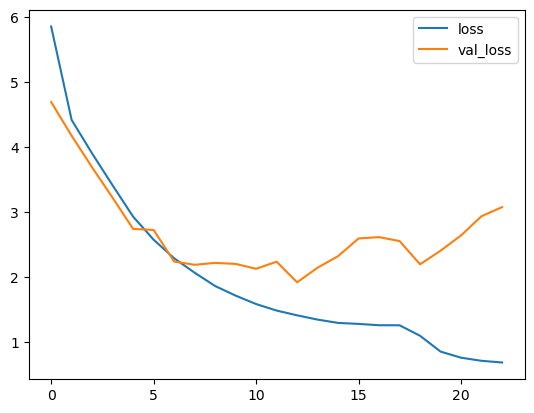

In [10]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

model.evaluate(test)

### ResNet-50 - training and evaluation

In [11]:
wandb.init(config=config, project='resnet-improved-labels', name='resnet50')

regularizer = L2(l2=config["l2"])
optimizer = SGD(learning_rate=config["learning_rate"], momentum=config["momentum"])
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = rn.ResNet50(
    len(classes),
    (image_size, image_size, channels),
    normalize=True,
    kernel_regularizer=regularizer
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

lr_schedule_sota = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=config["lr_reduce_patience"],
    verbose=1,
    mode="min"
)

callbacks = [
    early_stopping,
    lr_schedule_sota,
    WandbMetricsLogger()
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)
wandb.finish()

Epoch 1/100
574/574 [==============================] - 39s 57ms/step - loss: 19.9657 - sparse_categorical_accuracy: 0.1512 - val_loss: 17.3672 - val_sparse_categorical_accuracy: 0.1539 - lr: 0.1000
Epoch 2/100
574/574 [==============================] - 31s 55ms/step - loss: 15.7415 - sparse_categorical_accuracy: 0.1590 - val_loss: 14.2227 - val_sparse_categorical_accuracy: 0.1544 - lr: 0.1000
Epoch 3/100
574/574 [==============================] - 32s 55ms/step - loss: 12.9345 - sparse_categorical_accuracy: 0.1574 - val_loss: 11.7233 - val_sparse_categorical_accuracy: 0.1570 - lr: 0.1000
Epoch 4/100
574/574 [==============================] - 32s 55ms/step - loss: 10.7017 - sparse_categorical_accuracy: 0.1534 - val_loss: 9.7422 - val_sparse_categorical_accuracy: 0.1539 - lr: 0.1000
Epoch 5/100
574/574 [==============================] - 31s 54ms/step - loss: 8.9288 - sparse_categorical_accuracy: 0.1566 - val_loss: 8.1635 - val_sparse_categorical_accuracy: 0.1542 - lr: 0.1000
Epoch 6/100
5

epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
epoch/learning_rate,█████████████████████████████▂▂▂▂▂▂▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,██████████████████████████████▂▂▂▂▂▂▁▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇████
epoch/val_loss,█▇▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_sparse_categorical_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▄▄▄▅▆▅▆▆▆▆▆▅▆█████▇████
epoch/epoch,40
epoch/learning_rate,0.0001
epoch/loss,0.41411
epoch/lr,0.001


180/180 [==============================] - 7s 36ms/step - loss: 1.6825 - sparse_categorical_accuracy: 0.5593


[1.6825206279754639, 0.5592954158782959]

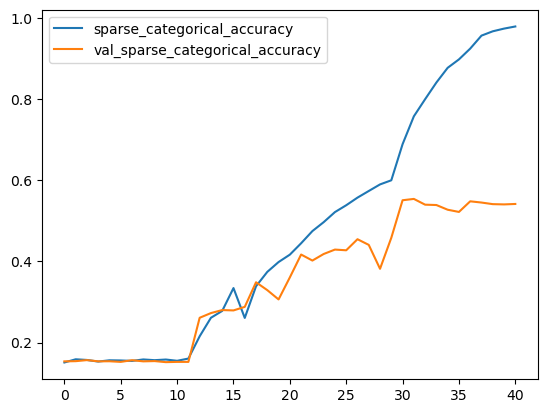

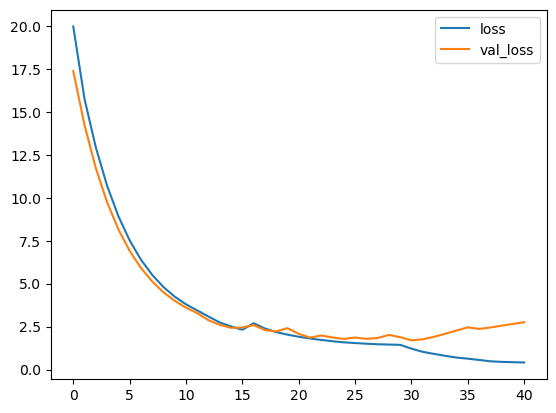

In [12]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

model.evaluate(test)

### ResNet-101 - training and evaluation

In [13]:
wandb.init(config=config, project='resnet-improved-labels', name='resnet101')

regularizer = L2(l2=config["l2"])
optimizer = SGD(learning_rate=config["learning_rate"], momentum=config["momentum"])
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = rn.ResNet101(
    len(classes),
    (image_size, image_size, channels),
    normalize=True,
    kernel_regularizer=regularizer
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

lr_schedule_sota = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=config["lr_reduce_patience"],
    verbose=1,
    mode="min"
)

callbacks = [
    early_stopping,
    lr_schedule_sota,
    WandbMetricsLogger()
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)
wandb.finish()

Epoch 1/100
574/574 [==============================] - 66s 95ms/step - loss: 117.9629 - sparse_categorical_accuracy: 0.1548 - val_loss: 107.2219 - val_sparse_categorical_accuracy: 0.1570 - lr: 0.1000
Epoch 2/100
574/574 [==============================] - 52s 90ms/step - loss: 96.0432 - sparse_categorical_accuracy: 0.1562 - val_loss: 85.6177 - val_sparse_categorical_accuracy: 0.1561 - lr: 0.1000
Epoch 3/100
574/574 [==============================] - 52s 90ms/step - loss: 76.7309 - sparse_categorical_accuracy: 0.1584 - val_loss: 68.4499 - val_sparse_categorical_accuracy: 0.1559 - lr: 0.1000
Epoch 4/100
574/574 [==============================] - 52s 90ms/step - loss: 61.3898 - sparse_categorical_accuracy: 0.1595 - val_loss: 54.8081 - val_sparse_categorical_accuracy: 0.1568 - lr: 0.1000
Epoch 5/100
574/574 [==============================] - 52s 90ms/step - loss: 49.2001 - sparse_categorical_accuracy: 0.1615 - val_loss: 43.9699 - val_sparse_categorical_accuracy: 0.1574 - lr: 0.1000
Epoch 6/

epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,█████████████████████████████████▂▂▂▂▂▁
epoch/loss,█▇▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,██████████████████████████████████▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇██
epoch/val_loss,█▇▅▅▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_sparse_categorical_accuracy,▁▁▁▁▁▁▁▁▁▁▃▂▄▂▅▅▅▅▆▆▇▇▆▆▆▆▇▇▇▆▇▇▇▆█████
epoch/epoch,38
epoch/learning_rate,0.001
epoch/loss,0.71271
epoch/lr,0.01


180/180 [==============================] - 6s 33ms/step - loss: 1.9541 - sparse_categorical_accuracy: 0.4990


[1.9540808200836182, 0.49895361065864563]

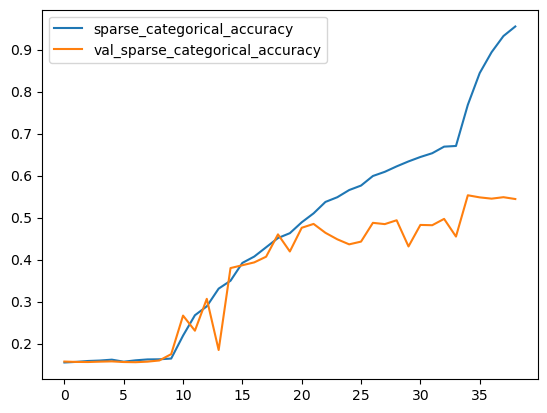

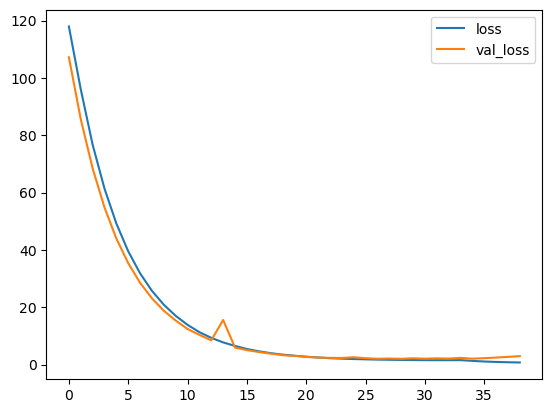

In [14]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

model.evaluate(test)

### ResNet-152 - training and evaluation

In [15]:
wandb.init(config=config, project='resnet-improved-labels', name='resnet152')

regularizer = L2(l2=config["l2"])
optimizer = SGD(learning_rate=config["learning_rate"], momentum=config["momentum"])
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = rn.ResNet152(
    len(classes),
    (image_size, image_size, channels),
    normalize=True,
    kernel_regularizer=regularizer
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

lr_schedule_sota = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=config["lr_reduce_patience"],
    verbose=1,
    mode="min"
)

callbacks = [
    early_stopping,
    lr_schedule_sota,
    WandbMetricsLogger()
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)
wandb.finish()

Epoch 1/100
574/574 [==============================] - 93s 131ms/step - loss: 1406.2384 - sparse_categorical_accuracy: 0.1492 - val_loss: 1286.2908 - val_sparse_categorical_accuracy: 0.1542 - lr: 0.1000
Epoch 2/100
574/574 [==============================] - 72s 125ms/step - loss: 1149.6893 - sparse_categorical_accuracy: 0.1554 - val_loss: 1022.3950 - val_sparse_categorical_accuracy: 0.1539 - lr: 0.1000
Epoch 3/100
574/574 [==============================] - 72s 125ms/step - loss: 913.9898 - sparse_categorical_accuracy: 0.1541 - val_loss: 812.8367 - val_sparse_categorical_accuracy: 0.1539 - lr: 0.1000
Epoch 4/100
574/574 [==============================] - 71s 124ms/step - loss: 726.5955 - sparse_categorical_accuracy: 0.1579 - val_loss: 646.2288 - val_sparse_categorical_accuracy: 0.1542 - lr: 0.1000
Epoch 5/100
574/574 [==============================] - 72s 125ms/step - loss: 577.7070 - sparse_categorical_accuracy: 0.1595 - val_loss: 513.8594 - val_sparse_categorical_accuracy: 0.1539 - lr

epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,████████████████████████████████████▂▂▂▁
epoch/loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,█████████████████████████████████████▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇▅▆▇▇▇▆▆▇▇▇███▇▅▇▇█
epoch/val_loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_sparse_categorical_accuracy,▁▁▁▁▁▂▂▃▃▃▄▅▆▆▆▆▇▆▅▅▇▇▅▆▇▇▄▇▇▆▄▇▇██▄▄███
epoch/epoch,59
epoch/learning_rate,0.001
epoch/loss,1.6458
epoch/lr,0.01


180/180 [==============================] - 8s 42ms/step - loss: 1.6998 - sparse_categorical_accuracy: 0.5218


[1.6998131275177002, 0.5217998027801514]

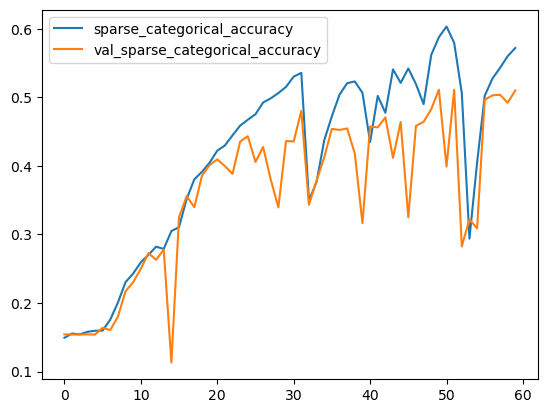

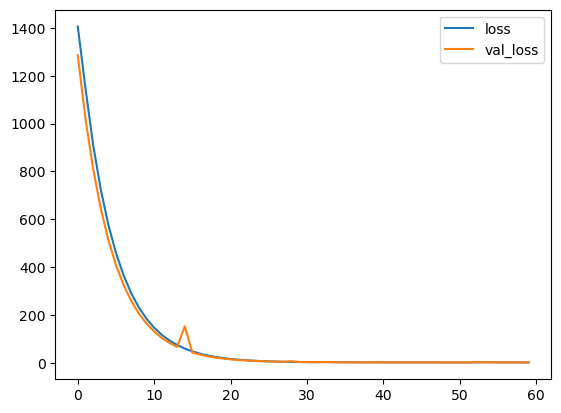

In [16]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

model.evaluate(test)